# Water Hyacinth Semantic Segmentation
This notebook trains a U-Net model to segment drone images, identifying water hyacinth, water, and background areas.
## 1. Setup and Installation
Install the dependencies below once to ensure all necessary libraries are installed. If you have them installed already, you can skip it.
Make sure you have a compatible PyTorch version installed (CPU or GPU). Check [pytorch.org](https://pytorch.org/) for instructions.

`!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Adjust cu118 based on your CUDA version if using GPU, or use cpu version`

`!pip install opencv-python numpy scikit-learn matplotlib Pillow segmentation-models-pytorch albumentations`

In [ ]:
# Import all necessary libraries.
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T # Use torchvision transforms minimally here
import albumentations as A # Use Albumentations for complex augmentations
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp # Library for segmentation models
from PIL import Image
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning) # Ignore some common user warnings

c:\Users\Billion\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Configuration ---
# Paths (Update these if your directory structure is different)
IMAGE_DIR = "./drone_images_downscaled/"
MASK_DIR = "./masks/"
MODEL_SAVE_DIR = "./models/"
PREDICTION_SAVE_DIR = "./predictions/"

# Data parameters
IMG_SIZE = 1024 # Should match your downscaled images
N_CLASSES = 3   # Background, Hyacinth, Water

# Model parameters
ENCODER = 'resnet34' # Choose a backbone for U-Net (e.g., resnet34, mobilenet_v2)
ENCODER_WEIGHTS = 'imagenet' # Use pre-trained weights

# Training parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50       # Start with a moderate number, increase if needed (can be high due to small dataset)
BATCH_SIZE = 2    # Adjust based on your GPU memory (can be 1 if needed)
LEARNING_RATE = 1e-4
TEST_SPLIT_RATIO = 0.20 # Use 20% of data for testing (e.g., 3 images out of 15)

# Class mapping (consistent with your mask generation)
CLASS_MAP = {
    "Background": 0,
    "Hyacinth": 1,
    "Water": 2,
}
# Create a reverse mapping for visualization colors
CLASS_COLORS = {
    0: (0, 0, 0),       # Background - Black
    1: (0, 255, 0),     # Hyacinth - Green
    2: (0, 0, 255),     # Water - Blue
}

# Create output directories if they don't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PREDICTION_SAVE_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  Image Directory: {os.path.abspath(IMAGE_DIR)}")
print(f"  Mask Directory: {os.path.abspath(MASK_DIR)}")
print(f"  Model Save Directory: {os.path.abspath(MODEL_SAVE_DIR)}")
print(f"  Prediction Save Directory: {os.path.abspath(PREDICTION_SAVE_DIR)}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Number of Classes: {N_CLASSES}")
print(f"  Encoder: {ENCODER} (Weights: {ENCODER_WEIGHTS})")
print(f"  Device: {DEVICE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")

Configuration:
  Image Directory: c:\Users\Billion\Desktop\Projs\Research Project\Research-Project-2025\ML\data\drone_images_downscaled
  Mask Directory: c:\Users\Billion\Desktop\Projs\Research Project\Research-Project-2025\ML\data\masks
  Model Save Directory: c:\Users\Billion\Desktop\Projs\Research Project\Research-Project-2025\ML\data\models
  Prediction Save Directory: c:\Users\Billion\Desktop\Projs\Research Project\Research-Project-2025\ML\data\predictions
  Image Size: 1024x1024
  Number of Classes: 3
  Encoder: resnet34 (Weights: imagenet)
  Device: cuda
  Epochs: 100
  Batch Size: 2
  Learning Rate: 0.0001


In [3]:
# --- Data Augmentation (using Albumentations) ---
# More augmentations can be added here
def get_train_transforms(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # Add more augmentations if needed (e.g., brightness/contrast, elastic transform)
        # A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet stats
        ToTensorV2(), # Converts image and mask to PyTorch tensors
    ])

def get_val_transforms(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

print("Augmentation functions defined.")

Augmentation functions defined.


In [4]:
# --- Dataset Class ---
class HyacinthDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image (using OpenCV for consistency, convert to RGB)
        image = cv2.imread(img_path)
        if image is None:
             raise IOError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (ensure it's loaded as grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
             raise IOError(f"Could not read mask: {mask_path}")

        # Apply transformations using Albumentations
        if self.transform:
            try:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask'] # Mask is already HxW tensor
            except Exception as e:
                print(f"Error applying transform to image: {img_path}, mask: {mask_path}")
                raise e

        # Ensure mask is LongTensor for CrossEntropyLoss
        mask = mask.long()

        return image, mask

print("HyacinthDataset class defined.")

HyacinthDataset class defined.


In [5]:
# --- Utility Functions ---
def get_file_paths(image_dir, mask_dir):
    """Gets corresponding image and mask paths."""
    if not os.path.isdir(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.isdir(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_filenames = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(".jpg")])
    mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith("_mask.png")])

    print(f"Found {len(image_filenames)} JPG images in {image_dir}")
    print(f"Found {len(mask_filenames)} PNG masks in {mask_dir}")

    # Important: Ensure mapping is correct. Assumes mask filename is derived from image filename.
    # Example: Image 'DJI_0001.JPG' -> Mask 'DJI_0001_mask.png'
    image_paths = []
    mask_paths = []
    # Create a mapping from the base image name (without ext) to the full mask path
    mask_name_map = {os.path.splitext(m)[0].replace('_mask', ''): os.path.join(mask_dir, m) for m in mask_filenames}

    for img_name in image_filenames:
        img_base_name = os.path.splitext(img_name)[0]
        if img_base_name in mask_name_map:
            image_paths.append(os.path.join(image_dir, img_name))
            mask_paths.append(mask_name_map[img_base_name])
        else:
            print(f"Warning: No corresponding mask found for image {img_name} (expected base name: {img_base_name})")

    print(f"Found {len(image_paths)} image/mask pairs.")
    if len(image_paths) == 0:
        raise FileNotFoundError("No image/mask pairs found. Check paths and naming conventions (e.g., 'image.JPG' -> 'image_mask.png').")
    return image_paths, mask_paths

def visualize_mask(mask_tensor, class_colors):
    """Converts a predicted mask tensor (HxW) to a color image (HxWx3)."""
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        mask_rgb[mask_np == class_id] = color
    return mask_rgb

print("Utility functions defined.")

Utility functions defined.


In [6]:
# --- Evaluation Metrics ---
def calculate_iou(pred, target, n_classes):
    """Calculates Intersection over Union (IoU) and Mean IoU (mIoU)."""
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item() # Cast to long before sum
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            iou.append(float('nan')) # Handle cases where class is not present in target or prediction
        else:
            iou.append(float(intersection) / float(max(union, 1))) # Avoid division by zero

    # Calculate mIoU - ignore NaN values (classes not present)
    valid_iou = [x for x in iou if not np.isnan(x)]
    miou = np.mean(valid_iou) if valid_iou else float('nan') # Return NaN if no valid classes

    return miou, iou # Return mean IoU and IoU for each class

def calculate_pixel_accuracy(pred, target):
    """Calculates overall pixel accuracy."""
    correct = (pred == target).sum().item()
    total = target.numel() # Total number of pixels
    if total == 0:
        return float('nan') # Avoid division by zero if target is empty
    return float(correct) / float(total)

print("Evaluation metric functions defined.")

Evaluation metric functions defined.


In [7]:
# --- Training Function ---
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    epoch_loss = 0.0
    num_batches = len(dataloader)
    if num_batches == 0:
        print("Warning: Training dataloader is empty.")
        return 0.0

    for i, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device) # Should be shape [B, H, W] and LongTensor

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images) # Output shape [B, N_CLASSES, H, W]

        # Calculate loss
        # Ensure mask is correct shape and type
        if masks.ndim == 4 and masks.shape[1] == 1: # If mask is [B, 1, H, W]
             masks = masks.squeeze(1) # Convert to [B, H, W]
        if masks.dtype != torch.long:
            masks = masks.long()

        loss = criterion(outputs, masks) # CrossEntropyLoss expects [B, C, H, W] and [B, H, W]

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # Use proper progress update for notebooks
        print(f"\r  Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}", end='')

    print() # New line after epoch progress is done
    return epoch_loss / num_batches

print("Training function defined.")

Training function defined.


In [8]:
# --- Evaluation Function ---
def evaluate(model, dataloader, criterion, n_classes, device):
    model.eval() # Set model to evaluation mode
    epoch_loss = 0.0
    total_miou = 0.0
    total_pix_acc = 0.0
    num_batches = len(dataloader)

    if num_batches == 0:
        print("Warning: Validation dataloader is empty.")
        return 0.0, 0.0, 0.0

    valid_miou_batches = 0
    valid_pix_acc_batches = 0

    with torch.no_grad(): # Disable gradient calculation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device) # Shape [B, H, W]

            outputs = model(images) # Shape [B, N_CLASSES, H, W]

            # Ensure mask is correct shape and type
            if masks.ndim == 4 and masks.shape[1] == 1: # If mask is [B, 1, H, W]
                 masks = masks.squeeze(1) # Convert to [B, H, W]
            if masks.dtype != torch.long:
                masks = masks.long()

            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            # Get predictions (class index with highest probability)
            preds = torch.argmax(outputs, dim=1) # Shape [B, H, W]

            # Calculate metrics for the batch
            miou, _ = calculate_iou(preds, masks, n_classes)
            pix_acc = calculate_pixel_accuracy(preds, masks)

            if not np.isnan(miou):
                total_miou += miou
                valid_miou_batches += 1
            if not np.isnan(pix_acc):
                total_pix_acc += pix_acc
                valid_pix_acc_batches += 1

    avg_loss = epoch_loss / num_batches
    avg_miou = total_miou / valid_miou_batches if valid_miou_batches > 0 else 0.0
    avg_pix_acc = total_pix_acc / valid_pix_acc_batches if valid_pix_acc_batches > 0 else 0.0

    return avg_loss, avg_miou, avg_pix_acc

print("Evaluation function defined.")

Evaluation function defined.


In [9]:
# --- Load and Split Data ---
try:
    image_paths, mask_paths = get_file_paths(IMAGE_DIR, MASK_DIR)

    # Split paths into training and validation sets
    img_train, img_val, mask_train, mask_val = train_test_split(
        image_paths, mask_paths, test_size=TEST_SPLIT_RATIO, random_state=42 # for reproducibility
    )
    print(f"\nData Split:")
    print(f"  Total samples: {len(image_paths)}")
    print(f"  Training samples: {len(img_train)}")
    print(f"  Validation samples: {len(img_val)}")

    if not img_train:
        print("Error: No training samples after split. Check dataset size and split ratio.")
    if not img_val:
        print("Warning: No validation samples after split. Consider adjusting split ratio or dataset size.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the IMAGE_DIR and MASK_DIR paths are correct and contain data.")
    # Optionally, you might want to stop execution here in a notebook
    # raise e
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    # raise e


Found 21 JPG images in ./drone_images_downscaled/
Found 15 PNG masks in ./masks/
Found 15 image/mask pairs.

Data Split:
  Total samples: 15
  Training samples: 12
  Validation samples: 3


In [10]:
# --- Create Datasets and DataLoaders ---
if 'img_train' in locals() and img_train: # Proceed only if data splitting was successful
    train_dataset = HyacinthDataset(img_train, mask_train, transform=get_train_transforms(IMG_SIZE))
    val_dataset = HyacinthDataset(img_val, mask_val, transform=get_val_transforms(IMG_SIZE))

    # Note: Due to the *very* small dataset, especially the validation set,
    # consider setting drop_last=False if the last batch size matters.
    # num_workers can be > 0 to speed up loading if not on Windows or if using appropriate multiprocessing start method
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0, # Safer default for notebooks/Windows
        drop_last=True # Drop last incomplete batch during training
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE, # Can use larger batch size for validation if memory allows
        shuffle=False,
        num_workers=0,
        drop_last=False # Keep all validation samples
    )

    print(f"\nDatasets and DataLoaders created:")
    print(f"  Train loader batches: {len(train_loader)}")
    print(f"  Validation loader batches: {len(val_loader)}")

    # Verify dataset loading for one sample (optional)
    try:
        img, msk = train_dataset[0]
        print(f"  Sample - Image shape: {img.shape}, Mask shape: {msk.shape}, Mask dtype: {msk.dtype}")
        # Check mask values
        unique_mask_vals = torch.unique(msk)
        print(f"  Sample - Unique mask values: {unique_mask_vals}")
        if not all(v in CLASS_MAP.values() for v in unique_mask_vals):
             print(f"  Warning: Mask contains unexpected values: {unique_mask_vals}. Expected values in {list(CLASS_MAP.values())}")

    except Exception as e:
        print(f"  Error loading sample from train_dataset: {e}")

else:
    print("\nSkipping Dataset/DataLoader creation due to previous errors.")


Datasets and DataLoaders created:
  Train loader batches: 6
  Validation loader batches: 2
  Sample - Image shape: torch.Size([3, 1024, 1024]), Mask shape: torch.Size([1024, 1024]), Mask dtype: torch.int64
  Sample - Unique mask values: tensor([0, 1, 2])


In [11]:
# --- Initialize Model, Loss, Optimizer ---
if 'train_loader' in locals(): # Proceed only if dataloaders were created
    print(f"\nInitializing U-Net model with encoder: {ENCODER} (pretrained: {ENCODER_WEIGHTS})")
    # Using U-Net from segmentation-models-pytorch
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,  # RGB images
        classes=N_CLASSES,
    ).to(DEVICE)

    # Loss Function (handles class imbalance somewhat implicitly)
    # Consider using weights if severe imbalance exists:
    # Calculate weights inversely proportional to class frequency if needed
    # weights = torch.tensor([background_weight, hyacinth_weight, water_weight]).float().to(DEVICE)
    # criterion = nn.CrossEntropyLoss(weight=weights)
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Optional: Learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    print("Model, Criterion, and Optimizer initialized.")
    # print(model) # Uncomment to see model structure
else:
    print("\nSkipping Model initialization due to previous errors.")


Initializing U-Net model with encoder: resnet34 (pretrained: imagenet)
Model, Criterion, and Optimizer initialized.


In [16]:
# --- Training Loop ---
if 'model' in locals() and 'train_loader' in locals() and 'val_loader' in locals(): # Check if everything is ready
    print("\n--- Starting Training ---")
    best_val_miou = -1.0
    best_model_path = None
    train_losses, val_losses = [], []
    val_mious, val_pix_accs = [], []

    start_time = time.time()

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training step
        train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validation step
        val_loss, val_miou, val_pix_acc = evaluate(model, val_loader, criterion, N_CLASSES, DEVICE)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_mious.append(val_miou)
        val_pix_accs.append(val_pix_acc)

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val mIoU:   {val_miou:.4f}")
        print(f"  Val PixAcc: {val_pix_acc:.4f}")

        # Optional: Learning rate scheduler step
        # scheduler.step(val_loss)

        # Save the best model based on validation mIoU
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            # Save model state dictionary
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_save_path = os.path.join(MODEL_SAVE_DIR, f"best_model_epoch_{epoch+1}_miou_{val_miou:.4f}_{timestamp}.pth")
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f"  Model improved and saved to {model_save_path}")
                best_model_path = model_save_path # Keep track of the latest best model path
            except Exception as e:
                 print(f"  Error saving model: {e}")


    end_time = time.time()
    total_time_minutes = (end_time - start_time) / 60
    print(f"\n--- Training Finished ---")
    print(f"Total training time: {total_time_minutes:.2f} minutes")
    print(f"Best Validation mIoU: {best_val_miou:.4f}")
    if best_model_path:
        print(f"Best model saved at: {best_model_path}")
    else:
        print("No best model was saved (validation mIoU might not have improved or saving failed).")

else:
    print("\nSkipping Training Loop due to previous errors or missing components.")


--- Starting Training ---

Epoch 1/100
  Batch 6/6, Loss: 0.1547
Epoch 1 Summary:
  Train Loss: 0.1854
  Val Loss:   0.1331
  Val mIoU:   0.9437
  Val PixAcc: 0.9744
  Model improved and saved to ./models/best_model_epoch_1_miou_0.9437_20250418-114944.pth

Epoch 2/100
  Batch 6/6, Loss: 0.1794
Epoch 2 Summary:
  Train Loss: 0.1759
  Val Loss:   0.1308
  Val mIoU:   0.9440
  Val PixAcc: 0.9746
  Model improved and saved to ./models/best_model_epoch_2_miou_0.9440_20250418-114946.pth

Epoch 3/100
  Batch 6/6, Loss: 0.1356
Epoch 3 Summary:
  Train Loss: 0.1507
  Val Loss:   0.1261
  Val mIoU:   0.9443
  Val PixAcc: 0.9746
  Model improved and saved to ./models/best_model_epoch_3_miou_0.9443_20250418-114948.pth

Epoch 4/100
  Batch 6/6, Loss: 0.1496
Epoch 4 Summary:
  Train Loss: 0.1355
  Val Loss:   0.1296
  Val mIoU:   0.9404
  Val PixAcc: 0.9728

Epoch 5/100
  Batch 6/6, Loss: 0.1474
Epoch 5 Summary:
  Train Loss: 0.1341
  Val Loss:   0.1317
  Val mIoU:   0.9402
  Val PixAcc: 0.9728

Ep


Training plots saved to training_plots.png


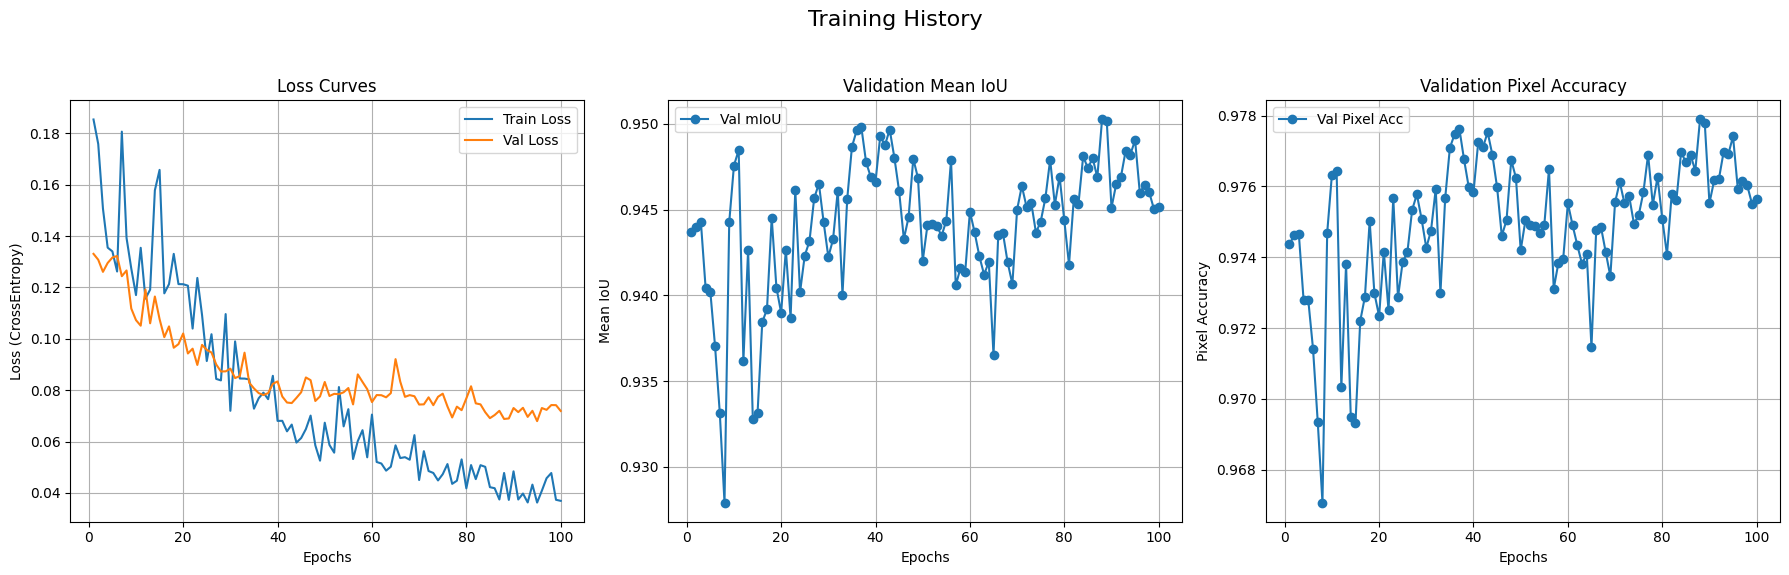

In [17]:
# --- Plot Training History ---
if 'train_losses' in locals() and train_losses: # Check if training actually ran
    plt.figure(figsize=(18, 6))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (CrossEntropy)')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    # mIoU Plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, EPOCHS + 1), val_mious, label='Val mIoU', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.title('Validation Mean IoU')
    plt.legend()
    plt.grid(True)

    # Pixel Accuracy Plot
    plt.subplot(1, 3, 3)
    plt.plot(range(1, EPOCHS + 1), val_pix_accs, label='Val Pixel Acc', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Pixel Accuracy')
    plt.title('Validation Pixel Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle("Training History", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap

    plot_filename = "training_plots.png"
    plt.savefig(plot_filename)
    print(f"\nTraining plots saved to {plot_filename}")
    plt.show()
else:
    print("\nSkipping plotting as training data is not available.")


--- Visualizing Predictions ---
Loading best model from: ./models/best_model_epoch_88_miou_0.9502_20250418-115203.pth
Visualizing 3 validation samples...
  Saved prediction visualization: ./predictions/validation_prediction_1.png


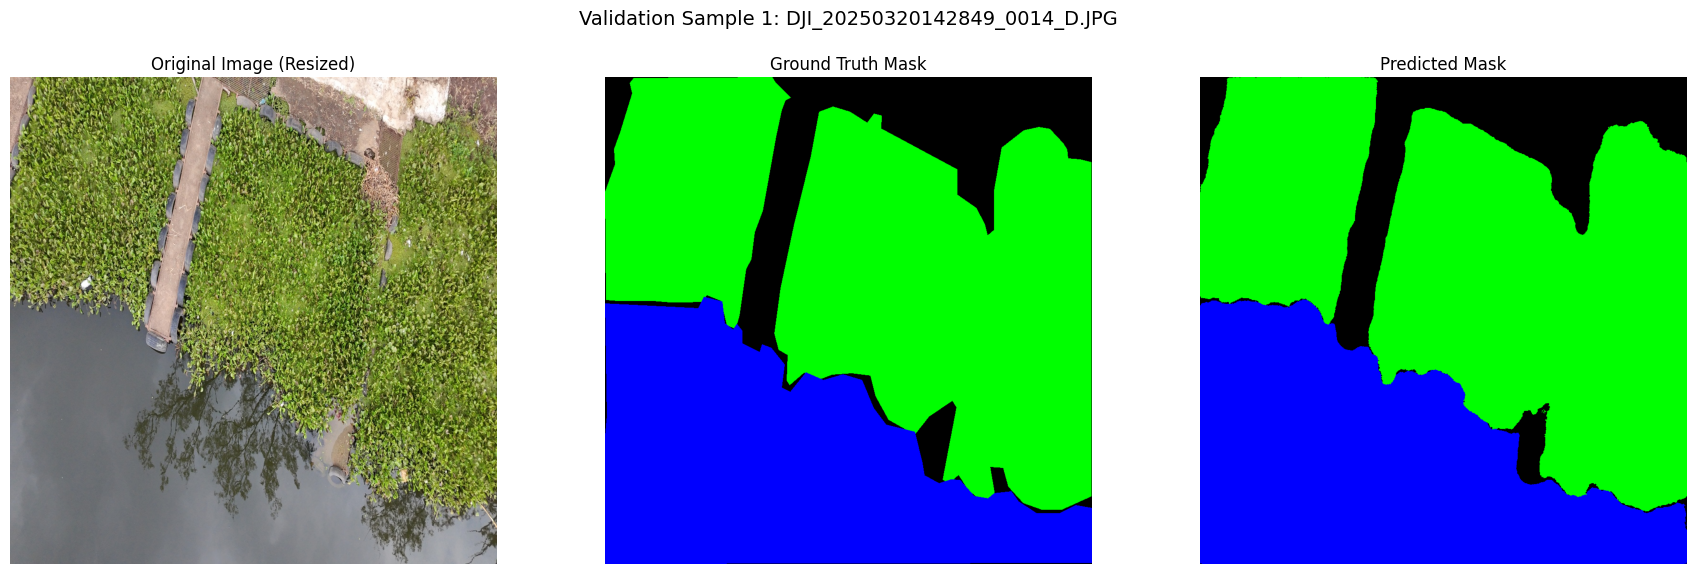

  Saved prediction visualization: ./predictions/validation_prediction_2.png


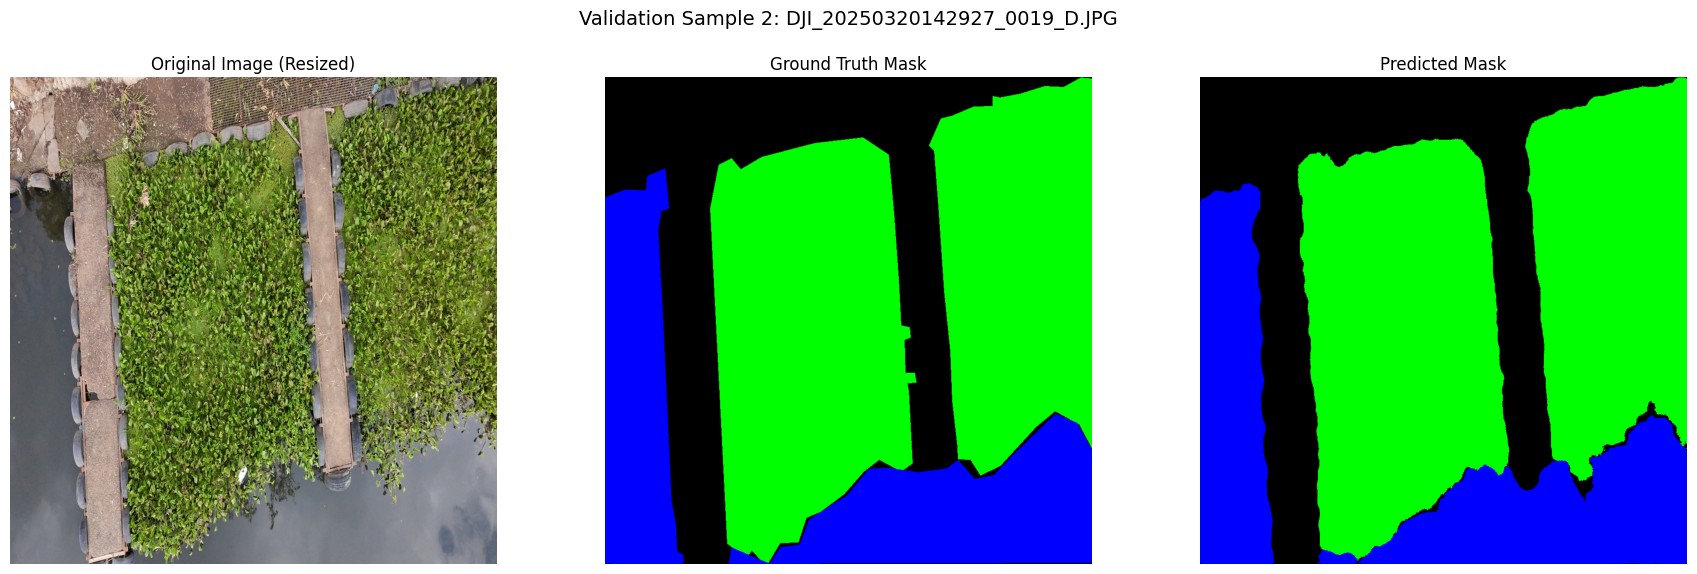

  Saved prediction visualization: ./predictions/validation_prediction_3.png


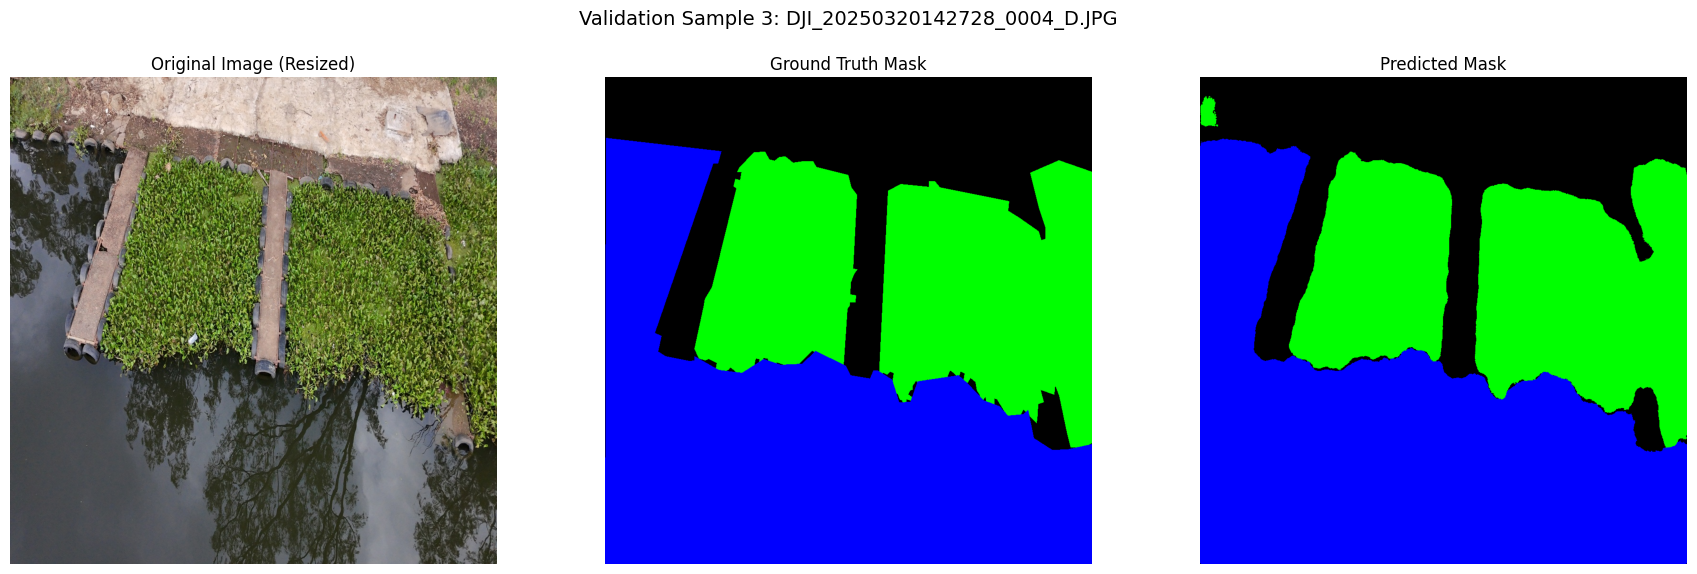

In [18]:
# --- Visualize Predictions on Validation Set ---
if 'model' in locals() and 'val_dataset' in locals() and 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    print(f"\n--- Visualizing Predictions ---")
    print(f"Loading best model from: {best_model_path}")
    try:
        # Load the state dict into the existing model structure
        model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
        model.eval() # Set model to evaluation mode

        num_visualize = min(len(val_dataset), 5) # Visualize up to 5 images from validation set
        print(f"Visualizing {num_visualize} validation samples...")

        # Define Denormalize transform (inverse of Normalize)
        # Calculate these based on the values used in get_train/val_transforms
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inv_normalize = T.Normalize(mean=-mean/std, std=1/std)

        with torch.no_grad():
            for i in range(num_visualize):
                # Get raw tensors from dataset BEFORE batching and augmentation
                # Need original image and mask for comparison
                # Re-load image and mask without train transforms for clean visualization
                orig_img_path = val_dataset.image_paths[i]
                orig_mask_path = val_dataset.mask_paths[i]

                # Load original image
                orig_img = cv2.imread(orig_img_path)
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
                orig_img_resized = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE)) # Resize for consistency

                # Load original mask
                gt_mask = cv2.imread(orig_mask_path, cv2.IMREAD_GRAYSCALE)
                if gt_mask is None:
                    print(f"  Warning: Could not load ground truth mask for visualization: {orig_mask_path}")
                    continue
                gt_mask_tensor = torch.from_numpy(gt_mask).long() # Convert GT mask to tensor for color mapping


                # Get the processed image tensor for model input *from the dataset*
                image_tensor, _ = val_dataset[i] # This already has val_transforms applied

                # Add batch dimension and move to device
                image_tensor_batch = image_tensor.unsqueeze(0).to(DEVICE) # Shape [1, C, H, W]

                # Predict
                pred_logits = model(image_tensor_batch) # Shape [1, N_CLASSES, H, W]
                pred_mask_tensor = torch.argmax(pred_logits, dim=1).squeeze(0).cpu() # Shape [H, W], move to CPU

                # Convert masks to color images for visualization
                gt_mask_vis = visualize_mask(gt_mask_tensor, CLASS_COLORS) # Use original GT mask tensor
                pred_mask_vis = visualize_mask(pred_mask_tensor, CLASS_COLORS) # Use predicted mask tensor

                # Plot
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                axes[0].imshow(orig_img_resized) # Show resized original image
                axes[0].set_title("Original Image (Resized)")
                axes[0].axis('off')

                axes[1].imshow(gt_mask_vis)
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis('off')

                axes[2].imshow(pred_mask_vis)
                axes[2].set_title("Predicted Mask")
                axes[2].axis('off')

                plt.suptitle(f"Validation Sample {i+1}: {os.path.basename(orig_img_path)}", fontsize=14)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                pred_filename = os.path.join(PREDICTION_SAVE_DIR, f"validation_prediction_{i+1}.png")
                try:
                    plt.savefig(pred_filename)
                    print(f"  Saved prediction visualization: {pred_filename}")
                except Exception as e:
                    print(f"  Error saving prediction plot: {e}")

                plt.show() # Display inline in the notebook
                # plt.close(fig) # Close the figure to free memory if generating many plots without plt.show()

    except Exception as e:
        print(f"An error occurred during prediction visualization: {e}")

elif not ('best_model_path' in locals() and best_model_path and os.path.exists(best_model_path)):
     print("\nSkipping prediction visualization: Best model path not found or does not exist.")
else:
     print("\nSkipping prediction visualization due to missing components (model or validation dataset).")